In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr
import scipy as sc
import networkx as nx
import networkx.drawing.nx_pylab as nxp
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample
import random
import time
import pickle
import pipedream_utility as pdu
from pipedream_utility import *
import pipedream_simulation as pd_sim
from pipedream_simulation import *
import pipedream_simulation_sensor_results as pd_sim_sensor
from pipedream_simulation_sensor_results import *
from pipedream_kalman_filter import apply_EKF
import viswaternet as vis
import matplotlib as mpl

#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
images_dir = 'img/'

In [2]:
%matplotlib inline

In [3]:
#Parameter for how many hours to run the model
t_run=24

# Time step
dt = 1800


In [4]:
# Net2

inp = 'networks/Net2.inp'

# Run pipedream simulation and extract head and flow results
H_net2_pd, Q_net2_pd, Q_pump, model, Q_in_all_df, pd_time = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# Run pipedream simulation and extract head and flow results
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

H_net2_wn = results.node['head']
Q_net2_wn= results.link['flowrate']

In [5]:
# CA1

inp = 'networks/CA1.inp'

# Run pipedream simulation and extract head and flow results
H_ca1_pd, Q_ca1_pd, Q_pump, model, Q_in_all_df, pd_time = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# Run pipedream simulation and extract head and flow results
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

H_ca1_wn = results.node['head']
Q_ca1_wn= results.link['flowrate']

In [6]:
# PA1

inp = 'networks/PA1.inp'

# Run pipedream simulation and extract head and flow results
H_pa1_pd, Q_pa1_pd, Q_pump, model, Q_in_all_df, pd_time = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# Run pipedream simulation and extract head and flow results
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

H_pa1_wn = results.node['head']
Q_pa1_wn= results.link['flowrate']

In [7]:
abs_diff_node_net2 = (H_net2_pd[H_net2_wn.columns] - H_net2_wn[H_net2_wn.columns]).abs().mean(axis=0)
abs_diff_link_net2 = (Q_net2_pd[Q_net2_wn.columns] - Q_net2_wn[Q_net2_wn.columns]).abs().mean(axis=0)

abs_diff_node_ca1 = (H_ca1_pd[H_ca1_wn.columns] - H_ca1_wn[H_ca1_wn.columns]).abs().mean(axis=0)
abs_diff_link_ca1 = (Q_ca1_pd[Q_ca1_wn.columns] - Q_ca1_wn[Q_ca1_wn.columns]).abs().mean(axis=0)

abs_diff_node_pa1 = (H_pa1_pd[H_pa1_wn.columns] - H_pa1_wn[H_pa1_wn.columns]).abs().mean(axis=0)
abs_diff_link_pa1 = (Q_pa1_pd[Q_pa1_wn.columns] - Q_pa1_wn[Q_pa1_wn.columns]).abs().mean(axis=0)

## Table 1: Comparison between PipeDream and EPANET simulation results.

In [8]:
print('Net2 head MAD [m]: ', abs_diff_node_net2.mean(), 'and flow MAD [10^-4 m^3/s]: ', 1e4*abs_diff_link_net2.mean())
print('CA1 head MAD [m]: ', abs_diff_node_ca1.mean(), 'and flow MAD [10^-4 m^3/s]: ', 1e4*abs_diff_link_ca1.mean())
print('PA1 head MAD [m]: ', abs_diff_node_pa1.mean(), 'and flow MAD [10^-4 m^3/s]: ', 1e4*abs_diff_link_pa1.mean())

Net2 head MAD [m]:  0.22016296815853825 and flow MAD [10^-4 m^3/s]:  0.13208712000139194
CA1 head MAD [m]:  0.026915376587823805 and flow MAD [10^-4 m^3/s]:  2.231743332422438
PA1 head MAD [m]:  0.09778981862498433 and flow MAD [10^-4 m^3/s]:  0.7887468546176736


In [9]:
net_list = ['./networks/Net2.inp', './networks/CA1.inp', './networks/PA1.inp']

In [10]:
max_limit_node = np.percentile(np.concatenate([abs_diff_node_net2.values, 
                                               abs_diff_node_ca1.values,
                                               abs_diff_node_pa1.values]), 99)
max_limit_link = np.percentile(np.concatenate([abs_diff_link_net2.values, 
                                               abs_diff_link_ca1.values,
                                               abs_diff_link_pa1.values]), 90)

In [11]:
fs = 18
cmap='coolwarm'

## Figure 2: Comparison between PipeDream and EPANET results: (top) heads and (bottom) flow rates.

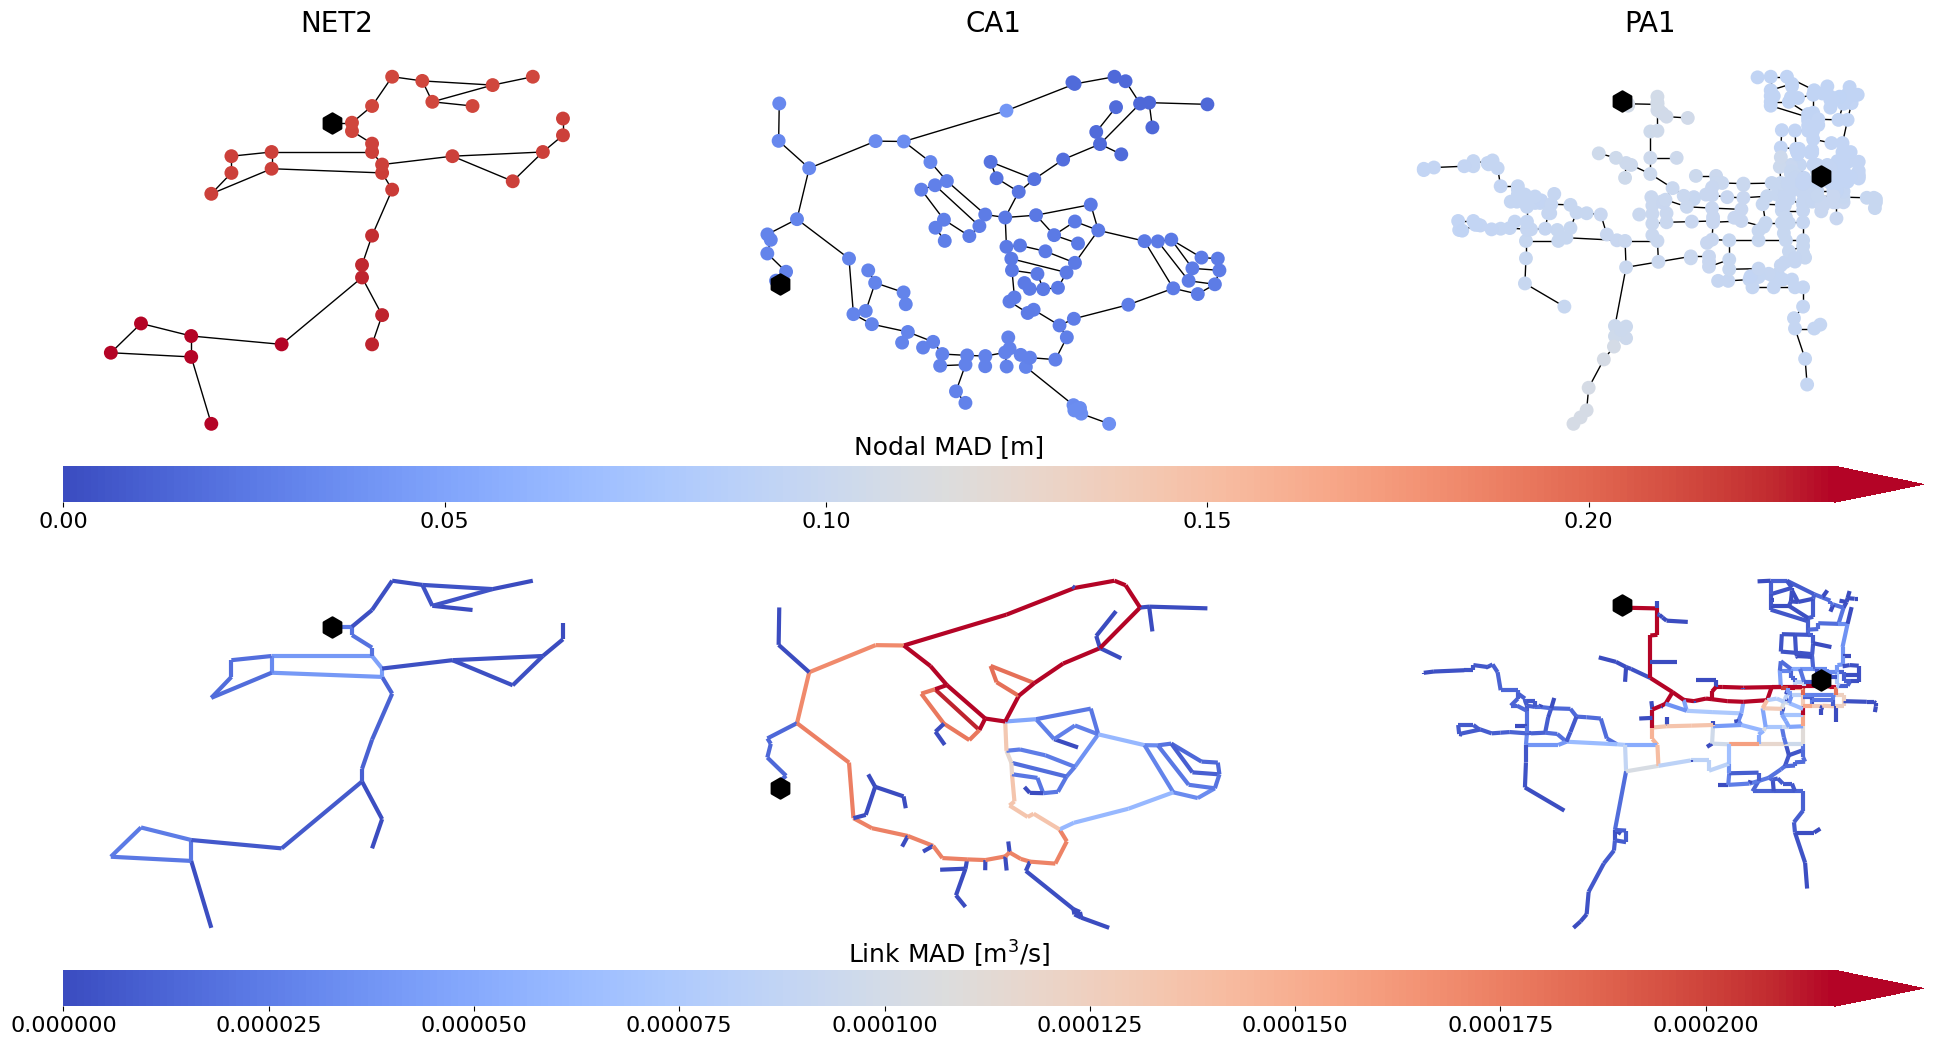

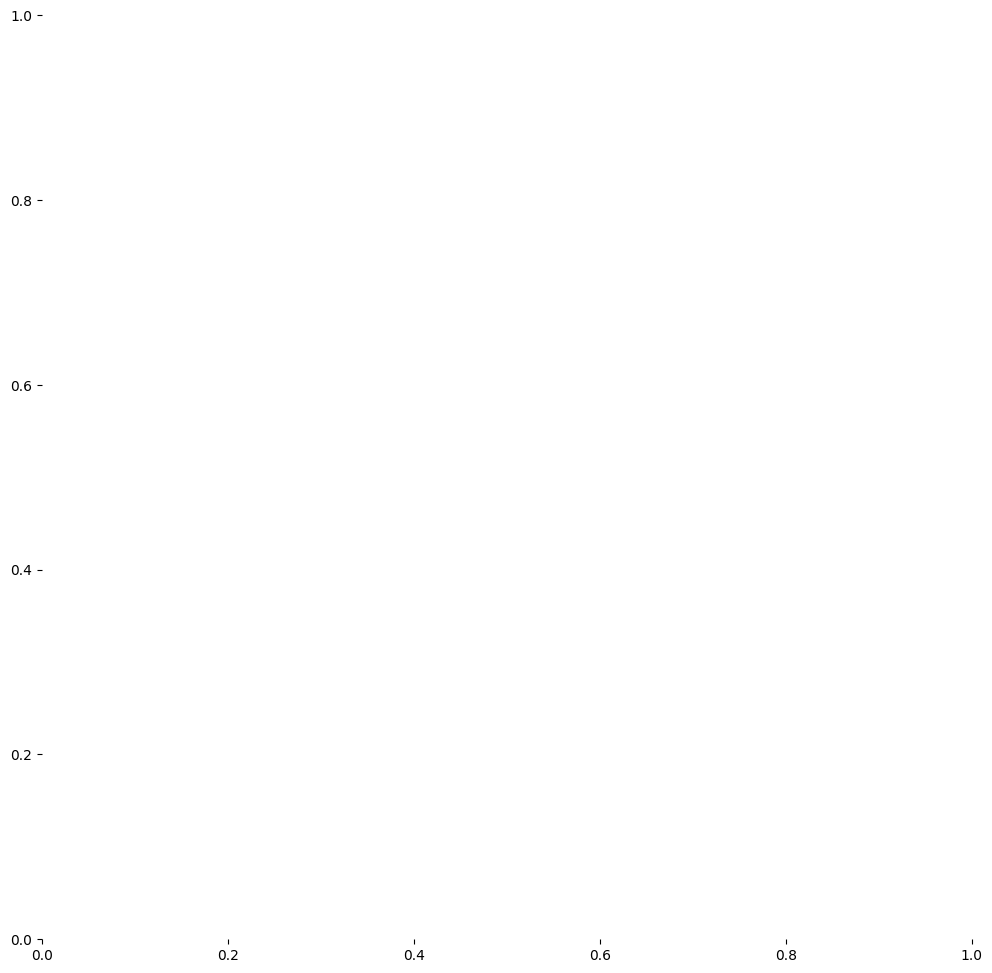

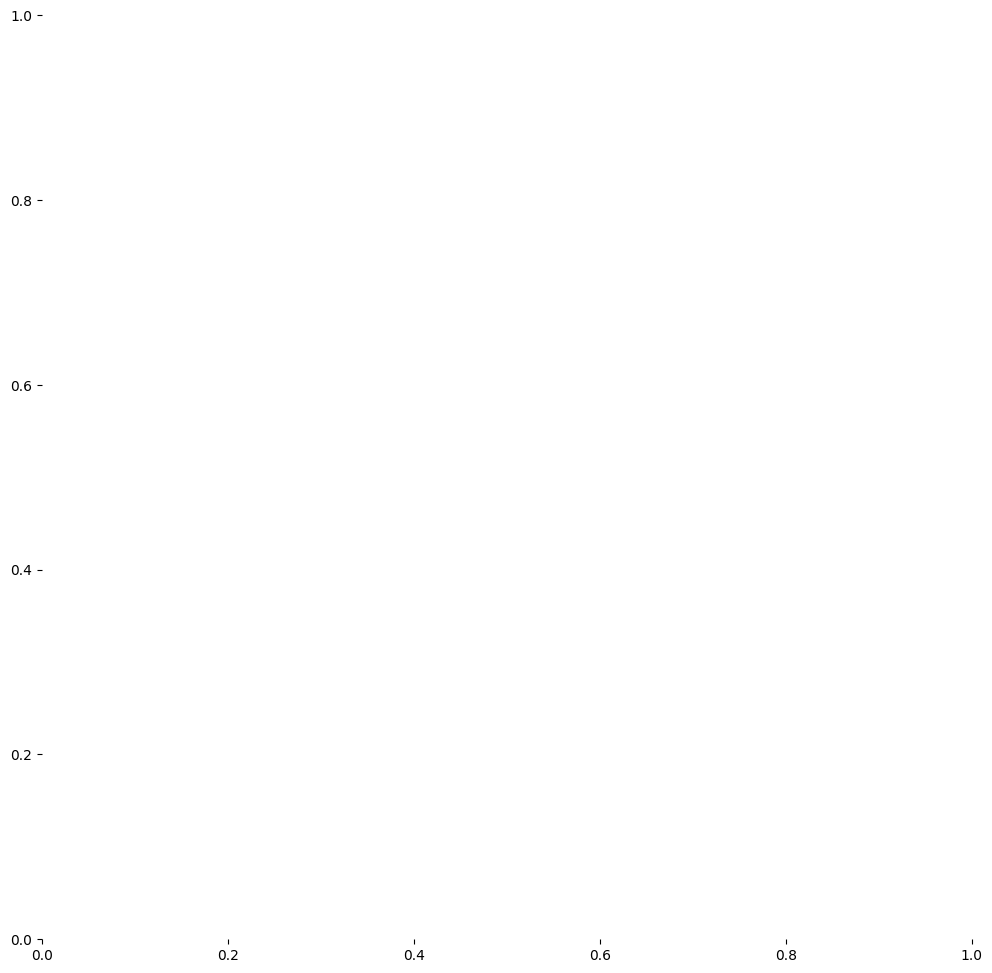

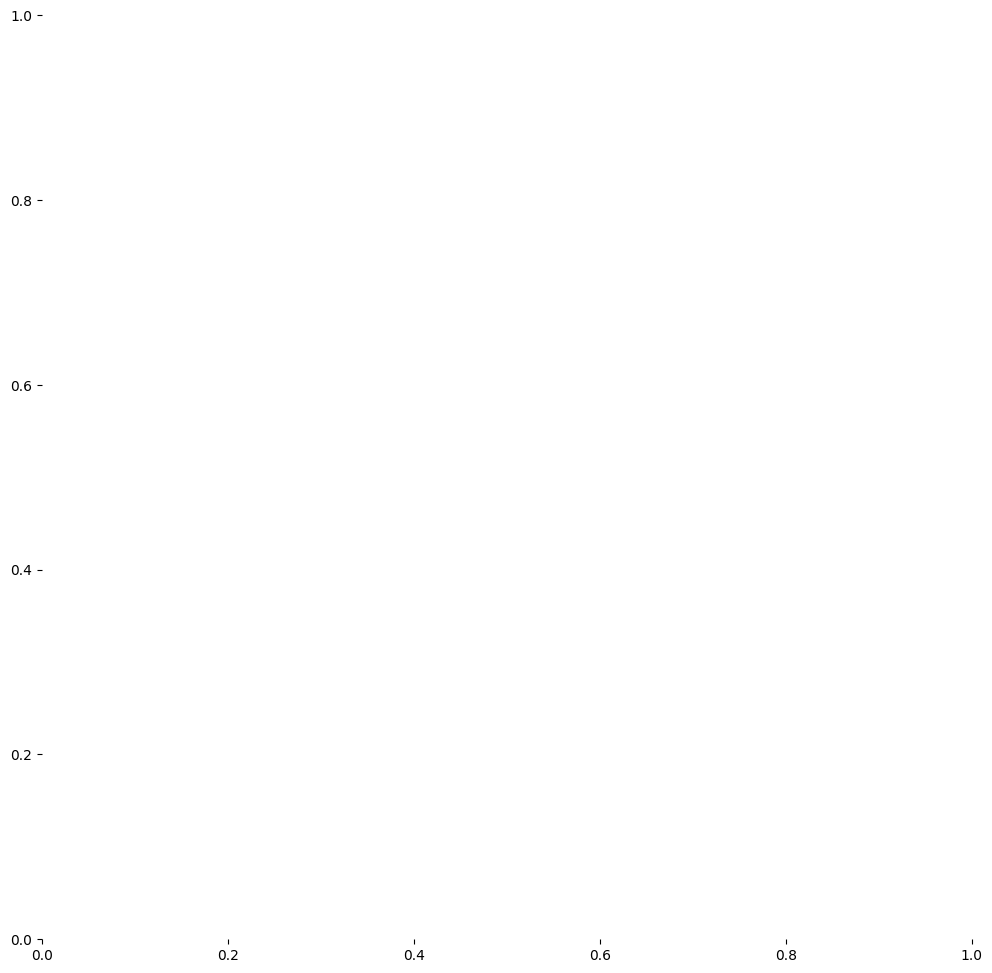

In [12]:
fig, ax = plt.subplots(2, 3, figsize = (24,12))
for inp in net_list:
    if inp == './networks/Net2.inp':
        axnum = 0
        name = 'NET2'
        abs_diff_node = abs_diff_node_net2
        abs_diff_link = abs_diff_link_net2
        node_size = 400
        
    if inp == './networks/CA1.inp':
        axnum = 1
        name = 'CA1'
        abs_diff_node = abs_diff_node_ca1
        abs_diff_link = abs_diff_link_ca1  
        node_size = 400
        
    if inp == './networks/PA1.inp':
        axnum = 2
        name = 'PA1'
        abs_diff_node = abs_diff_node_pa1
        abs_diff_link = abs_diff_link_pa1
        node_size = 400

    
    junction_names = list(abs_diff_node.index)
    link_names = list(abs_diff_link.index)
    junction_values = list(abs_diff_node.values)
    link_values = list(abs_diff_link.values)   
    
    vis_model = vis.VisWNModel(inp)
        
    ax[0][axnum].set_title(name, fontsize = fs+2)
    ax[0][axnum].set_frame_on(False) 
    vis_model.plot_unique_data(ax=ax[0][axnum], parameter = "custom_data", parameter_type = 'node', 
                                       custom_data_values = [junction_names, junction_values], data_type = 'continuous', 
                                       cmap = cmap, line_widths = 0, edge_colors = 'k', vmin = 0, vmax = max_limit_node, draw_color_bar = False,  
                                       node_size = node_size, tank_color='k', draw_base_legend=False)
    
    ax[1][axnum].set_frame_on(False) 
    vis_model.plot_unique_data(ax=ax[1][axnum], parameter = "custom_data", parameter_type = 'link', 
                                       custom_data_values = [link_names, link_values], data_type = 'continuous', 
                                       cmap = cmap, line_widths = 1,  vmin = 0, vmax = max_limit_link, draw_color_bar = False,  
                                       node_size = 0, tank_color='k', draw_base_legend=False, min_width=3, max_width = 3)
    
norm = mpl.colors.Normalize(vmin=0,vmax=max_limit_node)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
dims = [ax[0][0].get_position().x0,ax[0][0].get_position().y0-0.035,ax[0][2].get_position().x1-ax[0][0].get_position().x0,0.03]
# print(dims)
cax = fig.add_axes(dims)
cb = fig.colorbar(sm, cax=cax, orientation = 'horizontal', extend='max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Nodal MAD [m]',fontsize = fs, labelpad=-70)
cb.outline.set_visible(False)

norm2 = mpl.colors.Normalize(vmin=0,vmax=max_limit_link)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
sm2.set_array([])
dims = [ax[1][0].get_position().x0,ax[1][0].get_position().y0-0.035,ax[0][2].get_position().x1-ax[0][0].get_position().x0,0.03]
# print(dims)
cax2 = fig.add_axes(dims)
cb2 = fig.colorbar(sm2, cax=cax2, orientation = 'horizontal', extend='max')
cb2.ax.tick_params(labelsize=16)
cb2.set_label(label='Link MAD [m$^3$/s]',fontsize = fs, labelpad=-70)
cb2.outline.set_visible(False)
fig.savefig('img/fig2_epanet_comparison.pdf')

In [13]:
abs_diff_node_net2 = ((H_net2_pd[H_net2_wn.columns] - H_net2_wn[H_net2_wn.columns]) / H_net2_wn[H_net2_wn.columns]).abs().mean(axis=0)
abs_diff_link_net2 = ((Q_net2_pd[Q_net2_wn.columns] - Q_net2_wn[Q_net2_wn.columns]) / Q_net2_wn[Q_net2_wn.columns]).abs().mean(axis=0)

abs_diff_node_ca1 = ((H_ca1_pd[H_ca1_wn.columns] - H_ca1_wn[H_ca1_wn.columns]) / H_ca1_wn[H_ca1_wn.columns]).abs().mean(axis=0)
abs_diff_link_ca1 = ((Q_ca1_pd[Q_ca1_wn.columns] - Q_ca1_wn[Q_ca1_wn.columns]) / Q_ca1_wn[Q_ca1_wn.columns]).abs().mean(axis=0)

abs_diff_node_pa1 = ((H_pa1_pd[H_pa1_wn.columns] - H_pa1_wn[H_pa1_wn.columns]) / H_pa1_wn[H_pa1_wn.columns]).abs().mean(axis=0)
abs_diff_link_pa1 = ((Q_pa1_pd[Q_pa1_wn.columns] - Q_pa1_wn[Q_pa1_wn.columns]) / Q_pa1_wn[Q_pa1_wn.columns]).abs().mean(axis=0)

In [14]:
net_list = ['./networks/Net2.inp', './networks/CA1.inp', './networks/PA1.inp']

In [15]:
max_limit_node = np.percentile(np.concatenate([abs_diff_node_net2.values, 
                                               abs_diff_node_ca1.values,
                                               abs_diff_node_pa1.values]), 95)
max_limit_link = np.percentile(np.concatenate([abs_diff_link_net2.values, 
                                               abs_diff_link_ca1.values,
                                               abs_diff_link_pa1.values]), 95)

In [16]:
fs = 18
cmap='coolwarm'

/Users/mdbartos/miniconda3/lib/python3.8/site-packages/viswaternet/utils/normalize_parameter.py:31: RuntimeWarning: invalid value encountered in scalar divide
  * ((parameter - minParameter) / (maxParameter - minParameter))


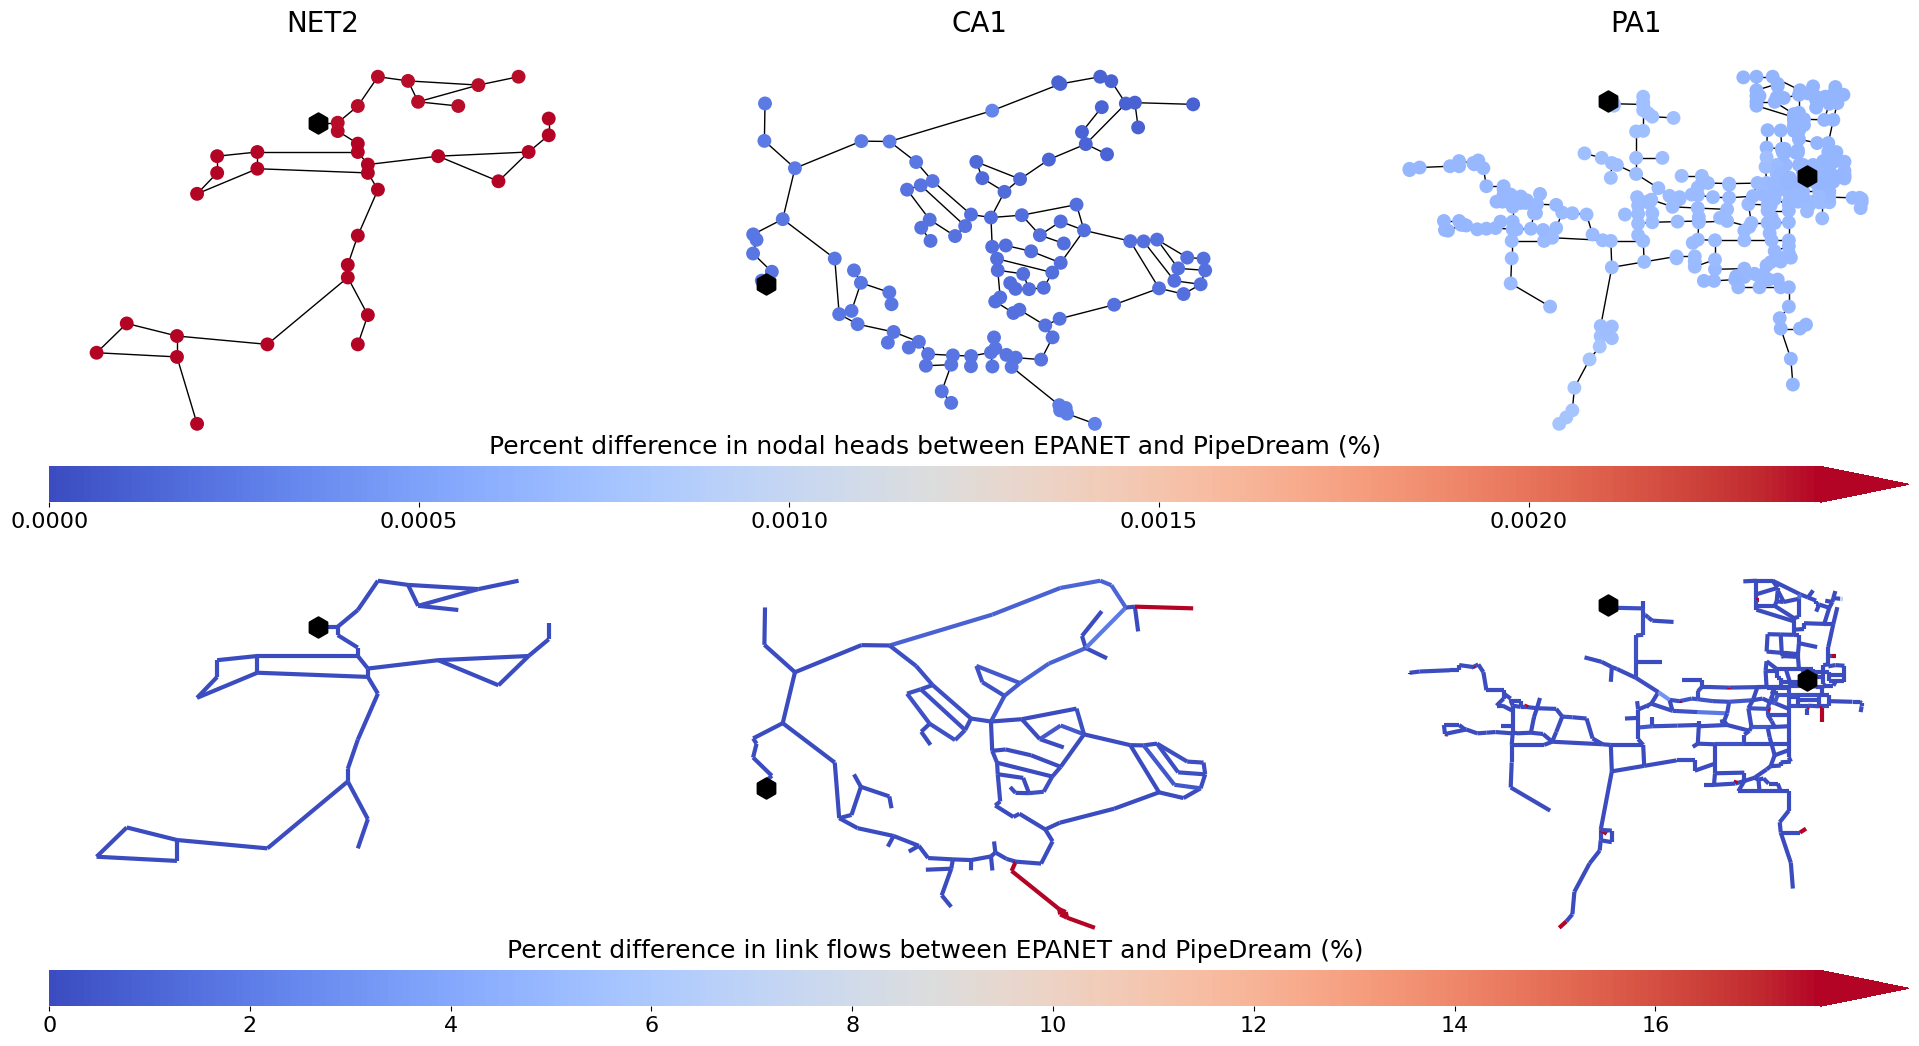

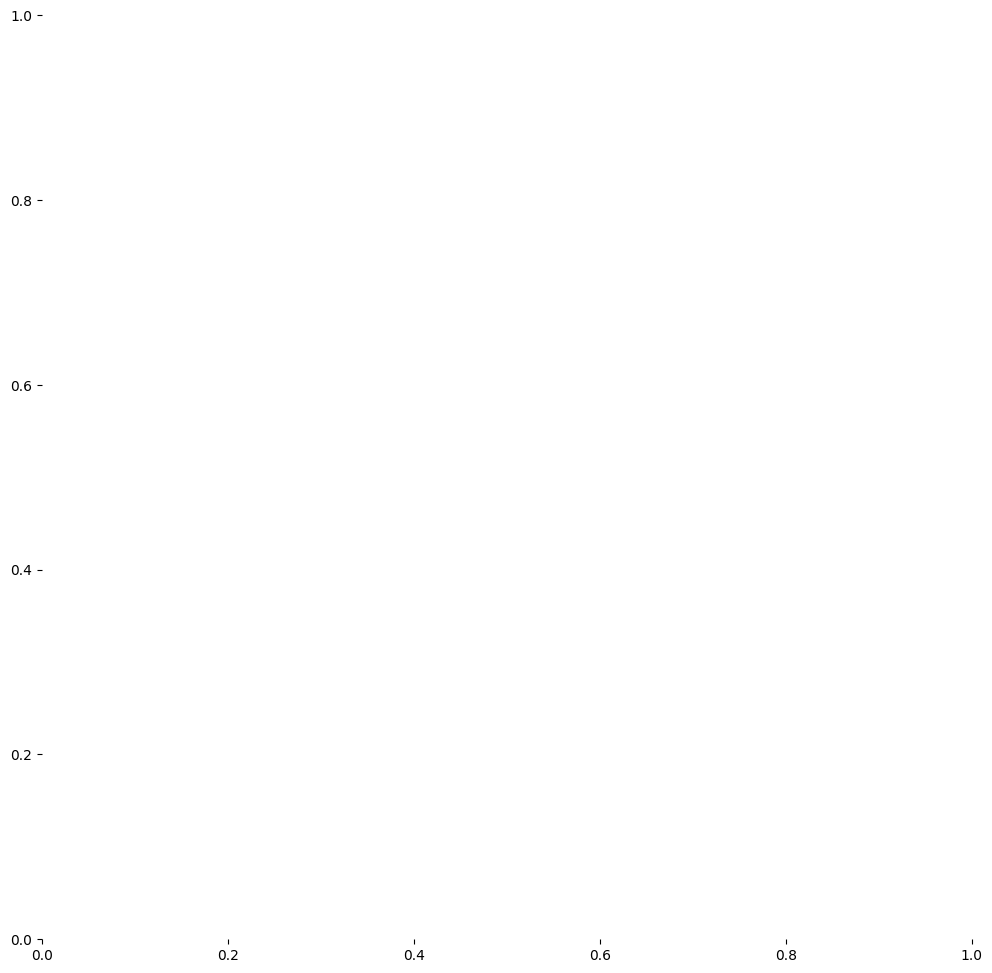

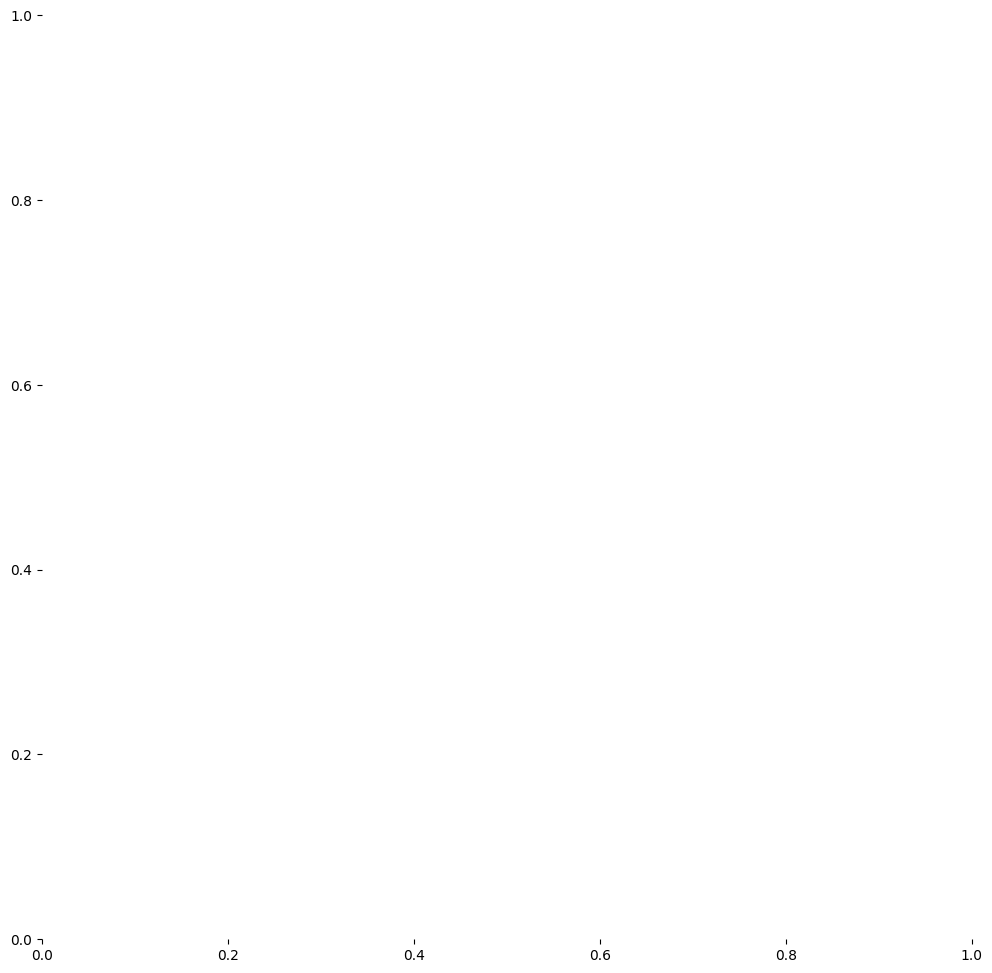

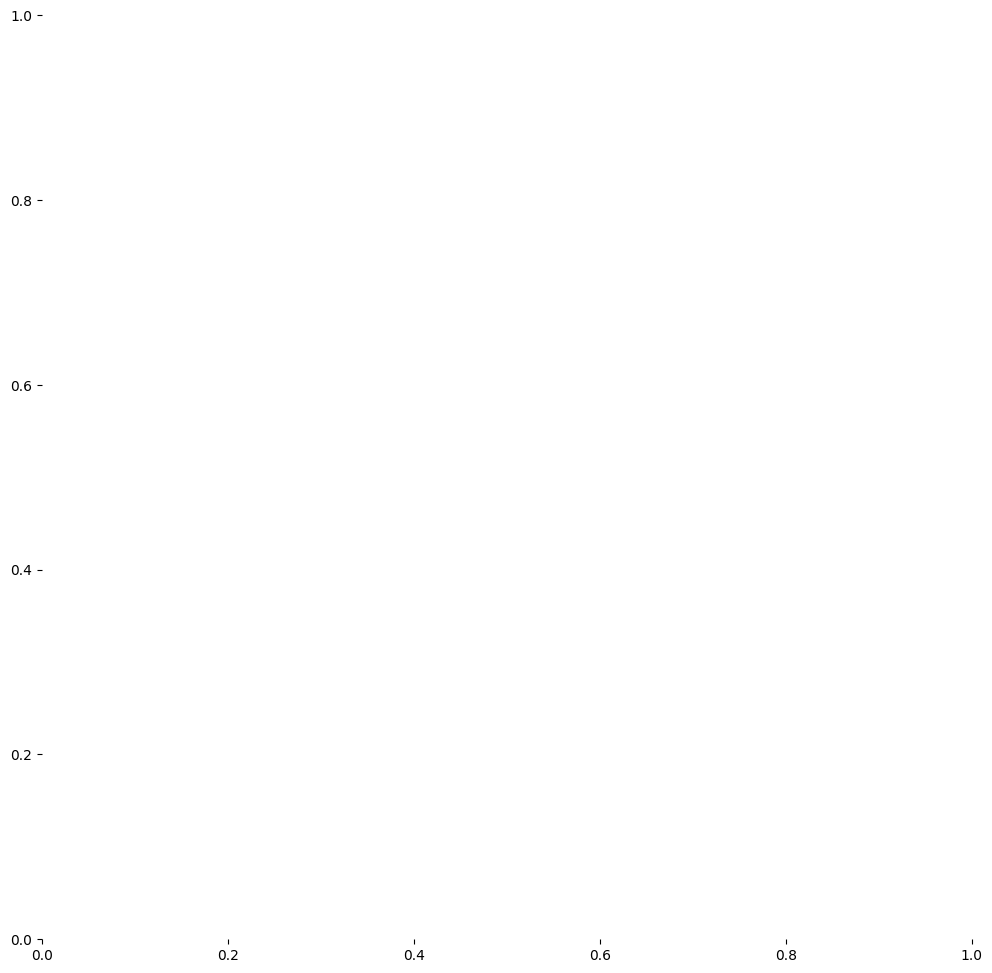

In [17]:
fig, ax = plt.subplots(2, 3, figsize = (24,12))
for inp in net_list:
    if inp == './networks/Net2.inp':
        axnum = 0
        name = 'NET2'
        abs_diff_node = abs_diff_node_net2
        abs_diff_link = abs_diff_link_net2
        node_size = 400
        
    if inp == './networks/CA1.inp':
        axnum = 1
        name = 'CA1'
        abs_diff_node = abs_diff_node_ca1
        abs_diff_link = abs_diff_link_ca1  
        node_size = 400
        
    if inp == './networks/PA1.inp':
        axnum = 2
        name = 'PA1'
        abs_diff_node = abs_diff_node_pa1
        abs_diff_link = abs_diff_link_pa1
        node_size = 400

    
    junction_names = list(abs_diff_node.index)
    link_names = list(abs_diff_link.index)
    junction_values = list(abs_diff_node.values)
    link_values = list(abs_diff_link.values)   
    
    vis_model = vis.VisWNModel(inp)
        
    ax[0][axnum].set_title(name, fontsize = fs+2)
    ax[0][axnum].set_frame_on(False) 
    vis_model.plot_unique_data(ax=ax[0][axnum], parameter = "custom_data", parameter_type = 'node', 
                                       custom_data_values = [junction_names, junction_values], data_type = 'continuous', 
                                       cmap = cmap, line_widths = 0, edge_colors = 'k', vmin = 0, vmax = max_limit_node, draw_color_bar = False,  
                                       node_size = node_size, tank_color='k', draw_base_legend=False)
    
    ax[1][axnum].set_frame_on(False) 
    vis_model.plot_unique_data(ax=ax[1][axnum], parameter = "custom_data", parameter_type = 'link', 
                                       custom_data_values = [link_names, link_values], data_type = 'continuous', 
                                       cmap = cmap, line_widths = 1,  vmin = 0, vmax = max_limit_link, draw_color_bar = False,  
                                       node_size = 0, tank_color='k', draw_base_legend=False, min_width=3, max_width = 3)
    
norm = mpl.colors.Normalize(vmin=0,vmax=max_limit_node)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
dims = [ax[0][0].get_position().x0,ax[0][0].get_position().y0-0.035,ax[0][2].get_position().x1-ax[0][0].get_position().x0,0.03]
# print(dims)
cax = fig.add_axes(dims)
cb = fig.colorbar(sm, cax=cax, orientation = 'horizontal', extend='max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Percent difference in nodal heads between EPANET and PipeDream (%)',fontsize = fs, labelpad=-70)
cb.outline.set_visible(False)

norm2 = mpl.colors.Normalize(vmin=0,vmax=max_limit_link)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
sm2.set_array([])
dims = [ax[1][0].get_position().x0,ax[1][0].get_position().y0-0.035,ax[0][2].get_position().x1-ax[0][0].get_position().x0,0.03]
# print(dims)
cax2 = fig.add_axes(dims)
cb2 = fig.colorbar(sm2, cax=cax2, orientation = 'horizontal', extend='max')
cb2.ax.tick_params(labelsize=16)
cb2.set_label(label='Percent difference in link flows between EPANET and PipeDream (%)',fontsize = fs, labelpad=-70)
cb2.outline.set_visible(False)
fig.savefig('img/epanet_comparison_pct.png', dpi=300)